## Model Compatibility Implementation 
### Use Case 1 - Length of Stay

#### Code
1. Importing required libraries and csv data for use case 2 (mortality prediction): There are 6 main libraries required to run this module. It includes pandas, sklearn, keras (Neural Network), scikitplot, matplotlib, and xgboost. We are using data set created under <b> Use case </b> section for Use case 1 - Length of stay prediction.
2. Data prep and one hot encoding: The predictor variable in this use case is Length of Stay. This is a left skewed conitinuous field. So to make it a normal distrinution a logarithmic transformation is done on LOS field. Also, we have categorical columns like ETHNICITY, ADMISSION_TYPE, INSURANCE and MARITAL_STATUS which are one hot encoded.
3. Split the data into test and train: The orignal dataset is split into test and train with 20:80 ratio. The train dataset is used as an input to generate synthetic data and finally the train datasets from orignal, TGAN and CTGAN are tested on the initially created test dataset. An importan thing to note is the test dataset was not considered for synthetic data generation and was kept as it is for comparison purposes.
3. Scaling on test and train dataset: Scaling on predictor variables of test and train is done to normalise the dataset. This step is important for regularisation.
4. Generate synthetic data: Post splitting dataset into train and test, we need to generate synthetic data using original train data. This task will be perfomed using TGAN and CTGAN in separate script. We will simply read the synthetic data generated by GAN algorithms in this script.
5. Data correction: The data generated by GAN algorithm treat numeric columns as continous columns rather than only integer values. As it try to replicate the distribution of data, it generate decimal values like 2.45 and also negative values like -2 for these numeric columns. In our use case, we can have only integer values and thus we need to correct data before building models.
6. Model fit function: Function created to train the model and predict using test data
7. Standardize and Hyperparameter tuning: Before implementing machine learning algorithms, we need to standardize data to bring different predictor variables to same scale. This is done to reduce bias caused by variables with high range as compared to other variables. Post which we implemneted Random Forest, XGBoost, KNN Regression and Neural Network, along with hyperparamter tuning using 5-fold cross validation to select best hyperparamters for model.
8. Compare metrics: There are number of metrics which can be used to compare the performance of regression models. We are reporting Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Explained Vairance Score and Coefficient of Determination (R-Squared). However, in case of Length of stay prediction, we want to predict the LOS and minimise the RMSE, because RMSE takes care of outlier situations of LOS as well while calculating the model performance.

<b> 1. Importing required libraries and csv data for use case 1 (Length of Stay Prediction) </b>
      
Need to first install and then import libraries. There are 6 main libraries required to run this module. It includes pandas, sklearn, keras (Neural Network), scikitplot, matplotlib, and xgboost. We are using data-set created under Use case section for Use case 1 - Length of Stay prediction.

# Importing Necessary libraries

In [8]:
#Importing necessary libraries required for modeling - linear regression, k-NN, regression tree, SVM regression
# & Neural Network
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold,RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn import linear_model
import seaborn as seabornInstance
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import utils
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.backend import sigmoid
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb1
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

# Data Import

In [9]:
#Loading data into dataframes
# the command below helps to import the dataset into the Jupyter notebook
los_use = pd.read_csv(r"C:\Users\poona\Desktop\ELP\data_used\los_usecase.csv")
los_predict = pd.read_csv(r"C:\Users\poona\Desktop\ELP\data_used\los_predict.csv")
los_tgan = pd.read_csv(r"C:\Users\poona\Desktop\ELP\data_used\los_usecase_tgan.csv")
los_ctgan = pd.read_csv(r"C:\Users\poona\Desktop\ELP\data_used\los_usecase_ctgan.csv")

#Evaluating quality of data
#Viewing top 5 rows to get a sense of the data

# Data Preparation

The predictor variable in this use case is Length of Stay. This is a left skewed conitinuous field. So to make it a normal distrinution a logarithmic transformation is done on LOS field

In [11]:
los_use['LOS']=np.log(los_use['LOS']+1)
los_predict['LOS']=np.log(los_predict['LOS']+1)
los_tgan['LOS']=np.log(los_tgan['LOS']+1)
los_ctgan['LOS']=np.log(los_ctgan['LOS']+1)

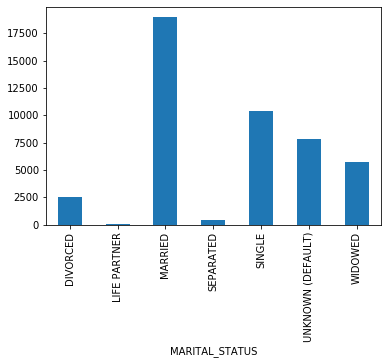

In [12]:
los_use.groupby('MARITAL_STATUS').size().plot.bar()
plt.show()

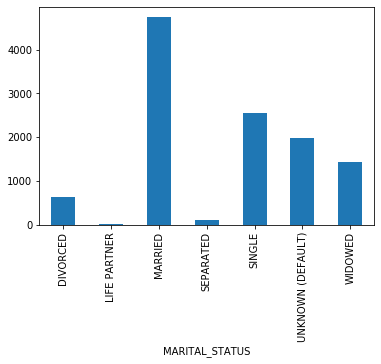

In [13]:
los_predict.groupby('MARITAL_STATUS').size().plot.bar()
plt.show()

The above two plots clearly show that the split of test and train dataset is perfect and there is no bias in either of the datasets.

## One Hot Encoding

We have categorical columns like ETHNICITY, ADMISSION_TYPE, INSURANCE and MARITAL_STATUS which are cnverted into dummy variables using one hot encoding

In [14]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE',
             'ETHNICITY', 'MARITAL_STATUS']
los_use = pd.get_dummies(los_use, prefix=prefix_cols, columns=dummy_cols)

In [15]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE',
             'ETHNICITY', 'MARITAL_STATUS']
los_predict = pd.get_dummies(los_predict, prefix=prefix_cols, columns=dummy_cols)

In [16]:
los_use.shape

(45736, 43)

In [17]:
los_predict.shape

(11435, 43)

## Selection of Features for the predictive model and the target variable (i.e. Length of Stay)

In [18]:
#Selecting the required columns - features and target variable.
X_train = los_use.iloc[:,1:43]
y_train = los_use.iloc[:,0]

In [19]:
#Selecting the required columns - features and target variable.
X_test = los_predict.iloc[:,1:43]
y_test = los_predict.iloc[:,0]

## Scaling

Scaling on test and train dataset: Scaling on predictor variables of test and train is done to normalise the dataset. This step is important for regularisation

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
x_train_scaled=scaler.transform(X_train)
x_test_scaled=scaler.transform(X_test)

## Data Exploration

The split of test and split is made sure to be similar for the predictor Variable "LOS" so that there is no bias in the split

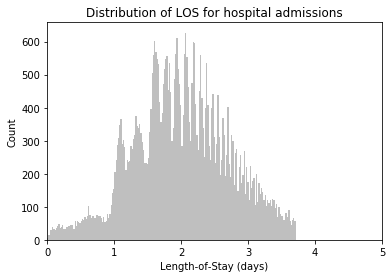

In [23]:
plt.hist(y_train, bins=200, color = '0.75')
plt.xlim(0, 5)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Log of Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

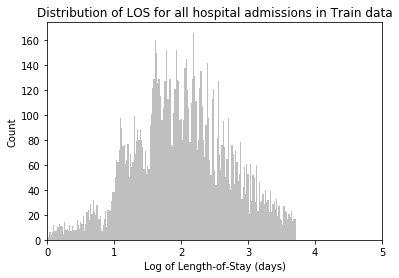

In [25]:
# Plot LOS Distribution
plt.hist(y_test, bins=200, color = '0.75')
plt.xlim(0, 5)
plt.title('Distribution of LOS for all hospital admissions in Train data')
plt.ylabel('Count')
plt.xlabel('Log of Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

# Model 1 - Random Forest

## Random Forest for Orignal Dataset

In [78]:
# importing required libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=123,
                            min_samples_split=1000,
                            min_samples_leaf=500,
                            criterion="mse")

params = {'n_estimators':[310,320,330],
          'max_depth':list(range(12,16,2)),
          'max_features':list(range(20,30,3))}

model = GridSearchCV(rf, params,
                     scoring='neg_mean_squared_error',
                     iid=True,n_jobs=-1, cv=5)
model.fit(x_train_scaled,y_train)
print("Best Score:",model.best_score_)
print("Best parameters:",model.best_params_)

Best Score: -0.39919683129382644
Best parameters: {'max_depth': 12, 'max_features': 26, 'n_estimators': 310}


In [79]:
# Model with best parameter
rf = RandomForestRegressor(n_jobs=-1,random_state=123,
                n_estimators=310,
                max_depth=12,
                max_features = 26,
                min_samples_split= 1000,
                min_samples_leaf=500,
                criterion="mse")
rf.fit(x_train_scaled,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=26, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=500, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, n_estimators=310, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [80]:
#predicting on the test set
y_pred = rf.predict(x_test_scaled)

## Results of Orignal Dataset

In [81]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 0.49474381261999767
Mean Squared Error: 0.40216756951715943
Root Mean Squared Error: 0.6341668309815324
Explained Variance Score: 0.23204382169282
Coefficient of Determination: 0.23199701065424982


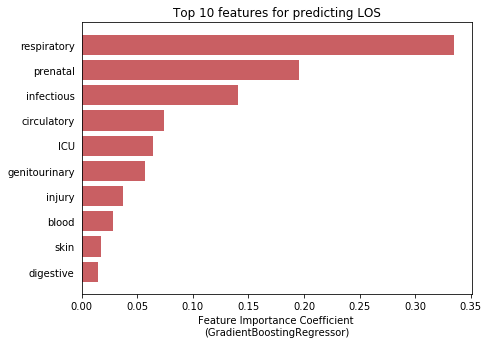

In [82]:
feature_imp = pd.DataFrame(rf.best_estimator_.feature_importances_,
                                   index = x_train_scaled.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(Random Forest Regressor)')
plt.gca().invert_yaxis()


## Random forest for TGAN generated Data

### Converting float to integers

In [ ]:
los_tgan.head(5).describe()

In [ ]:
los_tgan.iloc[:,5:23] = los_tgan.iloc[:,5:23].astype(int)

### One-Hot encoding for TGAN generated dataset

In [ ]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE',
             'ETHNICITY', 'MARITAL_STATUS']
los_tgan = pd.get_dummies(los_tgan, prefix=prefix_cols, columns=dummy_cols)

### Selection of Features for the predictive model and the target variable (i.e. Length of Stay)

In [ ]:
#Selecting the required columns - features and target variable. The model doesnot include the patient demographic details
X_train_tgan = los_tgan.iloc[:,1:43]
y_train_tgan = los_tgan.iloc[:,0]

### Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_tgan)
x_train_tgan_scaled=scaler.transform(X_train_tgan)

In [83]:
# importing required libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=123,
                            min_samples_split=1000,
                            min_samples_leaf=500,
                            criterion="mse")

params = {'n_estimators':[310,320,330],
          'max_depth':list(range(12,16,2)),
          'max_features':list(range(20,30,3))}

model = GridSearchCV(rf, params,
                     scoring='neg_mean_squared_error',
                     iid=True,n_jobs=-1, cv=5)
model.fit(x_train_tgan_scaled,y_train_tgan)
print("Best Score:",model.best_score_)
print("Best parameters:",model.best_params_)

Best Score: -0.3372495810953033
Best parameters: {'max_depth': 12, 'max_features': 23, 'n_estimators': 330}


In [84]:
# Model with best parameter
rf = RandomForestRegressor(n_jobs=-1,random_state=123,
                n_estimators=330,
                max_depth=12,
                max_features = 23,
                min_samples_split= 1000,
                min_samples_leaf=500,
                criterion="mse")
rf.fit(x_train_tgan_scaled,y_train_tgan)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=500, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, n_estimators=330, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [85]:
#predicting on the test set
y_pred_tgan = rf.predict(x_test_scaled)

### Results of TGAN generated Dataset

In [86]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_tgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_tgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_tgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_tgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_tgan))

Mean Absolute Error: 0.7279566282671975
Mean Squared Error: 0.778884563966444
Root Mean Squared Error: 0.8825443694038527
Explained Variance Score: -0.04340910078625271
Coefficient of Determination: -0.4874040544832323


## Random forest for CTGAN generated Data

In [ ]:
#Viewing top 5 rows to get a sense of the data
los_ctgan.head(5)

### Converting float to integers

In [ ]:
los_ctgan.iloc[:,5:23] = los_ctgan.iloc[:,5:23].astype(int)

### One-Hot encoding for CTGAN generated dataset

In [ ]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE',
             'ETHNICITY', 'MARITAL_STATUS']
los_ctgan = pd.get_dummies(los_ctgan, prefix=prefix_cols, columns=dummy_cols)

### Selection of Features for the predictive model and the target variable (i.e. Length of Stay)

In [ ]:
#Selecting the required columns - features and target variable. The model doesnot include the patient demographic details
X_train_ctgan = los_ctgan.iloc[:,1:43]
y_train_ctgan = los_ctgan.iloc[:,0]

### Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_tgan)
x_train_ctgan_scaled=scaler.transform(X_train_ctgan)

In [87]:
# importing required libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=123,
                            min_samples_split=1000,
                            min_samples_leaf=500,
                            criterion="mse")

params = {'n_estimators':[310,320,330],
          'max_depth':list(range(12,16,2)),
          'max_features':list(range(20,30,3))}

model = GridSearchCV(rf, params,
                     scoring='neg_mean_squared_error',
                     iid=True,n_jobs=-1, cv=5)
model.fit(x_train_ctgan_scaled,y_train_ctgan)
print("Best Score:",model.best_score_)
print("Best parameters:",model.best_params_)

Best Score: -0.4815609066792369
Best parameters: {'max_depth': 12, 'max_features': 20, 'n_estimators': 330}


In [88]:
# Model with best parameter
rf = RandomForestRegressor(n_jobs=-1,random_state=123,
                n_estimators=330,
                max_depth=12,
                max_features = 20,
                min_samples_split= 1000,
                min_samples_leaf=500,
                criterion="mse")
rf.fit(x_train_ctgan_scaled,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=500, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, n_estimators=330, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [89]:
#predicting on the test set
y_pred_ctgan = rf.predict(x_test_scaled)

### Results of CTGAN generated Dataset

In [90]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ctgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ctgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ctgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_ctgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_ctgan))

Mean Absolute Error: 0.5804768997622798
Mean Squared Error: 0.5224514901898464
Root Mean Squared Error: 0.7228080590238645
Explained Variance Score: 0.002452833230047413
Coefficient of Determination: 0.0022957178380246246


# Model 2 - XG Boost

## XG Boost for Orignal Dataset

In [91]:
import warnings
warnings.filterwarnings('ignore')
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb = xgb1.XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(x_train_scaled, y_train)
grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 0.8}

In [92]:
xg = xgb1.XGBRegressor(nthread=-1,colsample_bytree= 1.0,gamma= 0.5, max_depth= 4,min_child_weight= 5,subsample= 0.8)
xg.fit(x_train_scaled,y_train)

[04:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

### Results of orignal dataset

In [93]:
#predicting on the test set
y_pred = xg.predict(x_test_scaled)

In [94]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 0.47559520787158843
Mean Squared Error: 0.37467830476969993
Root Mean Squared Error: 0.6121097162843439
Explained Variance Score: 0.28456272924877657
Coefficient of Determination: 0.2844921373157866


## XG Boost for TGAN generated Data

In [95]:
import warnings
warnings.filterwarnings('ignore')
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb = xgb1.XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(x_train_tgan_scaled, y_train_tgan)
grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.4,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 0.9}

In [96]:
xg = xgb1.XGBRegressor(nthread=-1,colsample_bytree= 0.7,gamma= 0.4, max_depth= 4,min_child_weight= 5,subsample= 0.9)
xg.fit(x_train_tgan_scaled,y_train_tgan)

[04:23:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [97]:
#predicting on the test set
y_pred_tgan = xg.predict(x_test_scaled)

### Results of TGAN generated dataset

In [98]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_tgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_tgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_tgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_tgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_tgan))

Mean Absolute Error: 0.737410158105928
Mean Squared Error: 0.797439337832042
Root Mean Squared Error: 0.892994590035148
Explained Variance Score: -0.07522053317108623
Coefficient of Determination: -0.5228373486509403


## Comparing Result of XG Boost with CTGAN generated Data

In [99]:
import warnings
warnings.filterwarnings('ignore')
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb = xgb1.XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(x_train_ctgan_scaled, y_train_ctgan)
grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'max_depth': 2,
 'min_child_weight': 5,
 'subsample': 0.8}

In [100]:
xg = xgb1.XGBRegressor(nthread=-1,colsample_bytree= 0.7,gamma= 0.3, max_depth= 2,min_child_weight= 5,subsample= 0.8)
xg.fit(x_train_ctgan_scaled,y_train_ctgan)

[04:46:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [101]:
#predicting on the test set
y_pred_ctgan = xg.predict(x_test_scaled)

### Results of CTGAN generated dataset

In [102]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ctgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ctgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ctgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_ctgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_ctgan))

Mean Absolute Error: 0.543835273908177
Mean Squared Error: 0.4735598462798842
Root Mean Squared Error: 0.6881568471503311
Explained Variance Score: 0.09667335736798843
Coefficient of Determination: 0.09566209425161754


# Model 3 - Neural Network

Importing Necessary libraries

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Neural Network for Orignal Dataset

In [146]:
model = Sequential()
# Adding the input layer and first hidden layer
model.add(Dense(100, activation = 'relu', input_dim = 42))
# Adding the second hidden layer
model.add(Dense(units = 50, activation = 'relu'))
# Adding other hidden layers
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
#Finally, adding the output layer
model.add(Dense(units = 1))

In [147]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               4300      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________


In [148]:
neur_net_model = model.fit(x_train_scaled, y_train, batch_size=50, epochs = 100, verbose = 0, validation_split = 0.2)

In [149]:
neur_net_predict = model.predict(x_test_scaled)

### Results of orignal dataset

In [150]:
rms_nn = math.sqrt(metrics.mean_squared_error(y_test, neur_net_predict))
print('RMSE = {}'.format(rms_nn))

RMSE = 0.7080099344946935


In [151]:
ms_nn = metrics.mean_squared_error(y_test, neur_net_predict)
print('MSE = {}'.format(ms_nn))

MSE = 0.5012780673431801


In [152]:
mae_nn = metrics.mean_absolute_error(y_test, neur_net_predict)
print('MAE = {}'.format(mae_nn))

MAE = 0.5451481714502014


## Neural Network for TGAN generated Dataset

In [131]:
model = Sequential()
# Adding the input layer and first hidden layer
model.add(Dense(100, activation = 'relu', input_dim = 42))
# Adding the second hidden layer
model.add(Dense(units = 50, activation = 'relu'))
# Adding other hidden layers
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
#Finally, adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               4300      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________


In [132]:
neur_net_model = model.fit(x_train_tgan_scaled, y_train_tgan, batch_size=50, epochs = 100, verbose = 0, validation_split = 0.2)

In [133]:
neur_net_predict = model.predict(x_test_scaled)

### Results of TGAN generated dataset

In [134]:
rms_nn = math.sqrt(metrics.mean_squared_error(y_test, neur_net_predict))
print('RMSE = {}'.format(rms_nn))

RMSE = 0.9420184756122622


In [135]:
ms_nn = metrics.mean_squared_error(y_test, neur_net_predict)
print('MSE = {}'.format(ms_nn))

MSE = 0.8873988083948501


In [143]:
mae_nn = metrics.mean_absolute_error(y_test, neur_net_predict)
print('MAE = {}'.format(mae_nn))

MAE = 0.7748605521755945


## Neural Network for CTGAN generated Dataset

In [137]:
model = Sequential()
# Adding the input layer and first hidden layer
model.add(Dense(100, activation = 'relu', input_dim = 42))
# Adding the second hidden layer
model.add(Dense(units = 50, activation = 'relu'))
# Adding other hidden layers
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
#Finally, adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               4300      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________


In [138]:
neur_net_model = model.fit(x_train_ctgan_scaled, y_train_ctgan, batch_size=50, epochs = 100, verbose = 0, validation_split = 0.2)

In [139]:
neur_net_predict_ctgan = model.predict(x_test_scaled)

### Results of CTGAN generated dataset

In [140]:
rms_nn = math.sqrt(metrics.mean_squared_error(y_test, neur_net_predict_ctgan))
print('RMSE = {}'.format(rms_nn))

RMSE = 0.8886563821270672


In [141]:
ms_nn = metrics.mean_squared_error(y_test, neur_net_predict_ctgan)
print('MSE = {}'.format(ms_nn))

MSE = 0.7897101654951681


In [144]:
mae_nn = metrics.mean_absolute_error(y_test, neur_net_predict_ctgan)
print('MAE = {}'.format(mae_nn))

MAE = 0.6866950184854483


# Model 4-  KNN Regressor

## KNN Regressor for orignal Dataset

In [104]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
param={'n_neighbors':[2,4,6,8,10]}
regressor = GridSearchCV(knn, param, scoring="neg_mean_squared_error",cv=5)
regressor.fit(x_train_scaled,y_train)
regressor.best_params_

{'n_neighbors': 10}

In [105]:
knn = KNeighborsRegressor(10)
knn.fit(x_train_scaled,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [106]:
#predicting on the test set
y_pred = knn.predict(x_test_scaled)

### Results of orignal dataset

In [107]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 0.5100689976896554
Mean Squared Error: 0.42647409905508615
Root Mean Squared Error: 0.6530498442347921
Explained Variance Score: 0.20245437147192247
Coefficient of Determination: 0.1855798234898035


## KNN Regressor for TGAN generated Dataset

In [108]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
param={'n_neighbors':[2,4,6,8,10]}
regressor = GridSearchCV(knn, param, scoring="neg_mean_squared_error",cv=5)
regressor.fit(x_train_tgan_scaled,y_train_tgan)
regressor.best_params_

{'n_neighbors': 10}

In [109]:
knn = KNeighborsRegressor(10)
knn.fit(x_train_tgan_scaled,y_train_tgan)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [110]:
#predicting on the test set
y_pred_tgan = knn.predict(x_test_scaled)

### Results of TGAN generated dataset

In [111]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_tgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_tgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_tgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_tgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_tgan))

Mean Absolute Error: 0.7684822689157088
Mean Squared Error: 0.8697140558405797
Root Mean Squared Error: 0.932584610553155
Explained Variance Score: -0.1254402197801261
Coefficient of Determination: -0.6608574270757614


## KNN Regressor for TGAN generated Dataset

In [112]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
param={'n_neighbors':[2,4,6,8,10]}
regressor = GridSearchCV(knn, param, scoring="neg_mean_squared_error",cv=5)
regressor.fit(x_train_ctgan_scaled,y_train_ctgan)
regressor.best_params_

{'n_neighbors': 10}

In [115]:
knn = KNeighborsRegressor(10)
knn.fit(x_train_ctgan_scaled,y_train_ctgan)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [116]:
#predicting on the test set
y_pred_ctgan = knn.predict(x_test_scaled)

In [157]:
### Results of CTGAN generated dataset

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ctgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ctgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ctgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_ctgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_ctgan))